# RNN

In [70]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

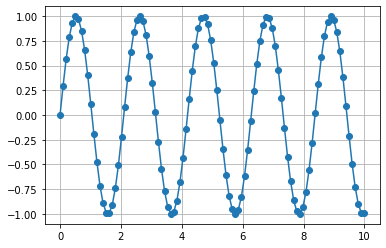

In [71]:
#Data

n_data = 100 #Amount of Data
domain_x = 10 #Domain of Data
x = np.linspace(0, domain_x, n_data) #Create X data
y_true = np.asarray([np.sin(3*x[i]) + 0.0 * np.random.rand()  for i in range(n_data)]) #Create target data

plt.plot(x, y_true, label='True data', marker='o')
plt.grid()

In [72]:
def MSE(x,y):
    return np.sum((x-y)**2)/x.shape[0]

In [73]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [74]:
def d_sig(x):
    return sigmoid(x)*(1-sigmoid(x))

In [75]:
#LSTM cell
class LSTM:
    
    def __init__(self, input_size, h_size):
        self.input_size = input_size
        self.h_size = h_size
        self.Wf = np.random.uniform(0,1,(h_size, input_size + h_size)) #Forget weights
        self.Wi = np.random.uniform(0,1,(h_size, input_size + h_size)) #Input weights
        self.Wo = np.random.uniform(0,1,(h_size, input_size + h_size)) #Output weights
        self.Wc = np.random.uniform(0,1,(h_size, input_size + h_size)) #Cell Input weights
        self.bf = np.random.randn(h_size) #Forget bias
        self.bi = np.random.randn(h_size) #Input bias
        self.bo = np.random.randn(h_size) #Output bias
        self.bc = np.random.randn(h_size) #Cell Input bias
        self.c_state = np.random.uniform(-1,1,(h_size)) #Cell state
        self.h_state = np.random.uniform(-1,1,(h_size)) #Hidden state
        
        self.concat = np.zeros((input_size + h_size)) #Concatenated Values
        
        self.f = 0 #forget gate
        self.i = 0 #input gate
        self.o = 0 #output gate
        self.c_hat = 0 #candidate cell state
        
        self.Wf_g = np.zeros((h_size, input_size + h_size)) #Forget gradient
        self.Wi_g = np.zeros((h_size, input_size + h_size)) #Input Gradient
        self.Wo_g = np.zeros((h_size, input_size + h_size)) #Output Gradient
        self.Wc_g = np.zeros((h_size, input_size + h_size)) #Cell Gradient
        self.bf_g = np.zeros(h_size) #Forget bias gradient
        self.bi_g = np.zeros(h_size) #Input bias gradient
        self.bo_g = np.zeros(h_size) #Output bias gradient
        self.bc_g = np.zeros(h_size) #Cell bias Gradient
        self.c_state_g = np.zeros(h_size) #Cell State Gradient
        self.h_state_g = np.zeros(h_size) #Hidden State Gradient
        
    def forward(self, x, h_prev, c_prev):
        self.concat = np.hstack((h_prev, x)) #Concatenated hidden state and input
        self.f = sigmoid(np.dot(self.Wf, self.concat) + self.bf) #Forget cell
        self.i = sigmoid(np.dot(self.Wi, self.concat) + self.bi) #Input cell
        self.o = sigmoid(np.dot(self.Wo, self.concat) + self.bo) #Output cell
        self.c_hat = np.tanh(np.dot(self.Wc, self.concat) + self.bc) #Cell state

        self.c_state = self.f * c_prev + self.i * self.c_hat #New Cell State
        self.h_state = self.o * np.tanh(self.c_state) #New Hidden State

        return self.h_state, self.c_state
    
    def backward(self, x, d_h_state, d_c_state):
        self.h_state_g = d_h_state 
        d_o = d_h_state * np.tanh(self.c_state) * d_sig(self.Wo * self.concat + self.bo)
        d_c = d_h_state * self.o * (1-np.tan(self.c_state)**2)
        d_i = d_c * self.c_hat * d_sig(self.Wi * self.concat + self.bi)
        d_f = d_c * d_c_state * d_sig(self.Wf * self.concat + self.bf)
        
        self.Wf_g = d_f * self.concat
        self.Wi_g = d_i * self.concat
        self.Wc_g = d_c * self.concat
        self.Wo_g = d_o * self.concat
        
        self.bf_g = d_f.sum()
        self.bi_g = d_i.sum()
        self.bc_g = d_c.sum()
        self.bo_g = d_o.sum()
        
        dconcat = self.Wf * d_f + self.Wi * d_i + self.Wc * d_c + self.Wo * d_o 
        
        dx = dconcat[:, :self.input_size] 
        dh_prev = dconcat[:, self.input_size:]

        return dx, dh_prev, d_c * self.f
    
    def update(self, x):
        
        return

In [76]:
#Forward Pass
L_Cell = LSTM(1,1)
H,C = L_Cell.forward(x[0],[0],[0])
print(H,C)

[0.08735761] [0.35661614]


In [77]:
Loss = MSE(y_true,H)
print(Loss)

0.5059738676095349


In [78]:
dX, dH, dC = L_Cell.backward(x[0],H,C)
print(dX,dH,dC)

[[0.01636189]] [[0.01818714]] [0.01468588]


In [79]:
class RNN:
    
    def __init__(self, input_size, h_size, out_size):
        self.input_size = input_size
        self.h_size = h_size
        self.out_size = out_size
        
        self.LSTM_Cells = []
        self.H = [np.zeros(h_size)]
        self.C = [np.zeros(h_size)]
        
        self.Wy = np.random.rand(out_size, h_size)
        self.by = np.zeros(out_size)
        
        self.dWy = np.zeros((out_size,h_size))
        self.dby = np.zeros(out_size)
        
        self.Losses = []
        
    def forward(self, x):
        for t in range(x.shape[0]):
            self.LSTM_Cells.append(LSTM(self.input_size,self.h_size))
            h,c = self.LSTM_Cells[t].forward(x[t],self.H[t],self.C[t])
            self.H.append(h)
            self.C.append(c)
        y = self.Wy * h + self.by
        return y
    
    def backward(self, x, dy):
        self.dWy = dy * self.H[-1].T
        self.dby = dy
        
        dh = self.Wy.T * dy
        dc = np.zeros_like(self.C[-1])
        for t in reversed(range(x.shape[0])):
            h_prev = self.H[t-1] if t > 0 else np.zeros_like(self.H[0])
            c_prev = self.C[t-1] if t > 0 else np.zeros_like(self.C[0])
            
            dx, dh, dc = self.LSTM_Cells[t].backward(x[t], h_prev, c_prev)
            
        return
    
    def train(self, x, yt, lr = 0.001, epochs = 100):
        for epoch in range(epochs):
            epoch_loss = 0
            for xt,target in zip(x,yt):
                out = self.forward(xt)
                loss = MSE(out,target)
                epoch_loss += loss
                
                dy = out - target
                self.backward(x,dy)
                
                self.Wy -= lr * self.dWy
                self.by -= lr * self.dby
                
                ###UPDATE ALL WEIGHTS FOR LSTM CELLS
                
            self.Losses.append(epoch_loss)
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(inputs)}')

In [80]:
R = RNN(1,1,1)
R.forward(x)

array([[0.84847384]])

In [81]:
R.backward(x,1)
R.dWy, R.dby

(array([0.96296761]), 1)

In [82]:
R.train(x,y_true)

IndexError: tuple index out of range